# Quick Start Examples

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:

import numpy as np
import pandas as pd
import os 
import fbprophet

# help ipython find our path
directory = os.path.dirname(os.path.dirname(os.path.abspath('')))
os.chdir(directory)

import forecastframe as ff


Importing plotly failed. Interactive plots will not work.


## Non-Hierarchical Example

### Prophet

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv")

In [34]:
fframe = ff.ForecastFrame(data=data, target="y", datetime_column="ds")

### Prophet

In [5]:
fframe.predict(model="prophet", future_periods=10, weekly_seasonality=True, daily_seasonality=True)
fframe.get_predictions()

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,y,predicted_y,trend,predicted_y_upper,predicted_y_lower
ds,,,,,
1992-01-01,146376.0,131335.258888,149250.780024,141080.785600,121859.305991
1992-02-01,147079.0,131131.825070,150289.708735,140992.239408,121849.146228
1992-03-01,159336.0,164783.266318,151261.609788,174433.600114,155208.497470
1992-04-01,163669.0,164876.320165,152300.538499,174296.387107,155503.847532
1992-05-01,170068.0,179316.575111,153305.953381,188597.005515,170968.906007
...,...,...,...,...,...
2016-05-07,NaN,474009.909550,448979.625130,482922.158852,463836.248139
2016-05-08,NaN,472531.169543,449025.071656,482194.693622,463264.845065
2016-05-09,NaN,477923.719431,449070.518182,487422.750499,469586.128530


In [6]:
fframe.get_errors()

,Actuals,Predictions,Absolute Percent Error,Absolute Error,Squared Error
count,293.000000,293.000000,293.000000,293.000000,2.930000e+02
mean,308971.310580,308971.430803,0.019505,5671.404632,5.252161e+07
std,86084.323897,85622.285250,0.016581,4519.567783,8.274258e+07
min,146376.000000,131131.825070,0.000001,0.331767,1.100694e-01
25%,234503.000000,235586.265327,0.008071,2234.232871,4.991797e+06
50%,314051.000000,318376.545866,0.015901,4640.050641,2.153007e+07
75%,375795.000000,370050.289741,0.024941,8033.921990,6.454390e+07
max,518253.000000,507987.462463,0.108426,22100.229318,4.884201e+08


In [7]:
fframe.cross_validate(folds=3, model="prophet")

In [8]:
# check that the latest round of predictions stored in the object were created using the params found in cross-validation
assert fframe.model_object.seasonality_mode == fframe.cross_validations[-1]["best_params"]["seasonality_mode"]

In [9]:
fframe.get_cross_validation_errors()

[{'In-Sample':              Actuals    Predictions  Absolute Percent Error  Absolute Error  \
  count      74.000000      74.000000               74.000000       74.000000   
  mean   198509.472973  198491.867873                0.050104    10083.191491   
  std     26907.419353   22375.499866                0.049940    10943.462357   
  min    146376.000000  155959.330002                0.000153       26.167567   
  25%    176693.500000  181545.230686                0.012393     2298.031114   
  50%    199172.500000  197959.748690                0.028598     5685.623925   
  75%    217961.000000  214673.898390                0.074053    14046.914810   
  max    271054.000000  240194.669356                0.179570    43296.390865   
  
         Squared Error  
  count   7.400000e+01  
  mean    2.198117e+08  
  std     4.325281e+08  
  min     6.847415e+02  
  25%     5.281192e+06  
  50%     3.232724e+07  
  75%     1.973184e+08  
  max     1.874577e+09  ,
  'Out-of-Sample':           

In [10]:
fframe.cross_validations[0]

{'train':            ds       y    predicted_y
 0  1992-01-01  146376  160452.498387
 1  1992-02-01  147079  155959.330002
 2  1992-03-01  159336  156451.703561
 3  1992-04-01  163669  162862.488087
 4  1992-05-01  170068  163700.440523
 ..        ...     ...            ...
 69 1997-10-01  232251  240194.669356
 70 1997-11-01  228284  232321.415795
 71 1997-12-01  271054  231008.248279
 72 1998-01-01  207853  231671.618930
 73 1998-02-01  203863  225286.000520
 
 [74 rows x 3 columns],
 'test':            ds       y    predicted_y
 0  1998-03-01  230313  225889.467947
 1  1998-04-01  234503  234661.483315
 2  1998-05-01  245027  235414.358755
 3  1998-06-01  244067  239774.172447
 4  1998-07-01  241431  248628.421302
 ..        ...     ...            ...
 68 2003-11-01  301265  305004.513365
 69 2003-12-01  357577  302976.983224
 70 2004-01-01  281460  303511.437231
 71 2004-02-01  282444  294805.307417
 72 2004-03-01  319077  297829.240455
 
 [73 rows x 3 columns],
 'best_estimator': 

### LightGBM

<AxesSubplot:xlabel='ds'>

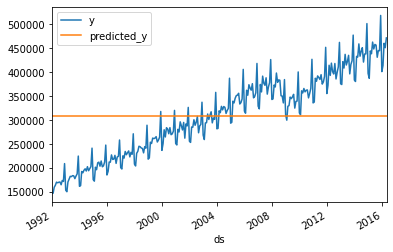

In [21]:
# Predictions are weak because our model doesn't have any features to grip on
# Note we can pass in lightgbm params as kwargs #TODO check
fframe.predict(model="lightgbm", future_periods=10, learning_rate=.04)
fframe.get_predictions().plot.line()

In [36]:
# Let's add some features to help our model out
fframe.calc_datetime_features()
fframe.lag_features(features=[fframe.target], lags=[1, 2, 3, 12]) # lagged features for 1 month ago, 2 months ago ..., 12 months ago
fframe.calc_statistical_features(features=[fframe.target], windows=[3, 6, 12], aggregations=['mean', 'std']) # 3, 6, and 12 month rolling aggregations for both mean and std
fframe.calc_ewma(fframe.target, windows=[3, 6, 12]) # 3, 6, 12 month exponential weighted moving averages
fframe.calc_percent_change(feature=fframe.target)


fframe.get_sample()

,y,day,day_of_week,weekend_flag,week,month,year,quarter,month_year,quarter_year,...,y_std_roll3_lag1,y_mean_roll6_lag1,y_std_roll6_lag1,y_mean_roll12_lag1,y_std_roll12_lag1,y_ewma_roll3_lag1,y_ewma_roll6_lag1,y_ewma_roll12_lag1,y_pct_change,y_pct_change_lag1
ds,,,,,,,,,,,,,,,,,,,,,
1992-01-01,146376,1,2,False,1,1,92,1,92M01,92Q1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-02-01,147079,1,5,True,5,2,92,1,92M02,92Q1,...,NaN,146376.0,NaN,146376.0,NaN,NaN,NaN,NaN,NaN,NaN
1992-03-01,159336,1,6,True,10,3,92,1,92M03,92Q1,...,NaN,147079.0,NaN,147079.0,NaN,NaN,NaN,NaN,0.004803,0.004803
1992-04-01,163669,1,2,False,14,4,92,2,92M04,92Q2,...,NaN,159336.0,NaN,159336.0,NaN,153982.571429,NaN,NaN,0.083336,0.083336
1992-05-01,170068,1,4,False,18,5,92,2,92M05,92Q2,...,NaN,163669.0,NaN,163669.0,NaN,159148.666667,NaN,NaN,0.027194,0.027194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-01-01,400928,1,4,False,1,1,16,1,16M01,16Q1,...,NaN,518253.0,NaN,518253.0,NaN,481216.663058,465590.525363,454208.103167,0.165905,0.165905
2016-02-01,413554,1,0,False,6,2,16,1,16M02,16Q1,...,NaN,400928.0,NaN,400928.0,NaN,441072.331529,447115.518116,446011.164218,-0.226386,-0.226386
2016-03-01,460093,1,1,False,10,3,16,1,16M03,16Q1,...,NaN,413554.0,NaN,413554.0,NaN,427313.165764,437526.512940,441017.754338,0.031492,0.031492


In [27]:
fframe.get_sample()

,y,day,day_of_week,weekend_flag,week,month,year,quarter,month_year,quarter_year,y_lag7,y_lag14,y_lag21,y_lag28,y_lag56,y_lag365
ds,,,,,,,,,,,,,,,,
1992-01-01,11.893941,1,2,False,1,1,92,1,92M01,92Q1,NaN,NaN,NaN,NaN,NaN,NaN
1992-02-01,11.898732,1,5,True,5,2,92,1,92M02,92Q1,NaN,NaN,NaN,NaN,NaN,NaN
1992-03-01,11.978777,1,6,True,10,3,92,1,92M03,92Q1,NaN,NaN,NaN,NaN,NaN,NaN
1992-04-01,12.005607,1,2,False,14,4,92,2,92M04,92Q2,NaN,NaN,NaN,NaN,NaN,NaN
1992-05-01,12.043960,1,4,False,18,5,92,2,92M05,92Q2,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-01-01,12.901540,1,4,False,1,1,16,1,16M01,16Q1,13.013062,12.989771,12.974828,12.889674,12.878943,NaN
2016-02-01,12.932546,1,0,False,6,2,16,1,16M02,16Q1,13.033993,13.124826,13.036420,12.937818,12.870401,NaN
2016-03-01,13.039186,1,1,False,10,3,16,1,16M03,16Q1,13.030996,12.892329,12.978846,12.956573,12.859962,NaN


In [16]:
# Pass in a heavier parameter dictionary
params = ff.get_lgb_params("full")

{'max_depth': [10, 20], 'n_estimators': [150, 200, 300], 'min_split_gain': [0, 0.0001, 0.001, 0.01, 0.1], 'min_child_samples': [2, 4, 7, 10, 14, 20, 30, 40, 60, 80, 100, 130, 170, 200, 300, 500, 700, 1000], 'min_child_weight': [0, 0.1, 0.0001, 0.005, 0.02], 'num_leaves': [10, 20, 30, 50], 'learning_rate': [0.001, 0.04, 0.05, 0.07, 0.1, 0.1], 'colsample_bytree': [0.3, 0.5, 0.7, 0.8, 0.9, 1], 'colsample_bynode': [0.1, 0.15, 0.2, 0.2, 0.2, 0.25, 0.3, 0.5, 0.65, 0.8, 0.9, 1], 'reg_lambda': [0, 0.1, 0.01, 0.001, 0.0001, 1e-05, 0.1, 1, 10, 100], 'reg_alpha': [0, 1e-05, 3e-05, 0.0001, 0.0001, 0.001, 0.003, 0.01, 0.1, 1, 1, 10, 10, 100, 1000], 'subsample': [0.9, 1], 'subsample_freq': [1], 'cat_smooth': [1]}
